# Imports

In [2]:
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from pymoo.algorithms.moo.rvea import RVEA
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv.monte_carlo import ApproximateMonteCarloHypervolume
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.radviz import Radviz
from pymoo.visualization.scatter import Scatter

import numpy as np

from ell_moo import DQMOO
from utils import get_local_ref_dirs

## R-metric functions

In [7]:
def ASF(x, z_r, w):
    """
    Achievement Scalarization Function for a solution.
    """
    return np.max((x - z_r) / w)

def pivot_point(S, z_r, w):
    """
    Find pivot point (solution with minimum ASF value).
    """
    asf_values = np.array([ASF(x, z_r, w) for x in S])
    
    return S[np.argmin(asf_values)]

def trim(S, pivot, extent):
    """
    Trim solutions outside ROI defined by pivot and extent.
    """
    lower = pivot - extent / 2
    upper = pivot + extent / 2
    trimmed = []
    
    for x in S:
        if np.all(x >= lower) and np.all(x <= upper):
            trimmed.append(x)
    
    return np.array(trimmed)

def iso_ASF_point(z_p, z_r, z_w):
    """
    Compute iso-ASF point on reference line.
    """
    k = np.argmax((z_p - z_r) / (z_w - z_r))
    delta = (z_p[k] - z_r[k]) / (z_w[k] - z_r[k])
    
    return z_r + delta * (z_w - z_r)

def transfer(S, pivot, iso_point):
    """
    Transfer trimmed solutions along preferred direction.
    """
    direction = iso_point - pivot
    transferred = []
    
    for x in S:
        transferred.append(x + direction)
    
    return np.array(transferred)

# 3-objective problem example

## Experiments runs

### Initialize and run the Ellipsoid-based approach

In [3]:
problem = get_problem("dtlz1", n_obj=3)

ref_dir = np.array([0.6, 0.3, 0.1])

algorithm = DQMOO(ref_dir, pop_size=300, beta=3, gamma=0.1, adapt_gamma=True)

res = minimize(
    problem,
    algorithm,
    termination=('n_gen', 1000),
    seed=0,
    verbose=True
    )

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      300 |    300 |  4.054163E+01 |  3.916855E+02
     2 |      600 |     21 |  4.054163E+01 |  2.044772E+02
     3 |      900 |     20 |  4.054163E+01 |  1.514620E+02
     4 |     1200 |     26 |  4.054163E+01 |  1.381142E+02
     5 |     1500 |     17 |  4.054163E+01 |  1.087372E+02
     6 |     1800 |     22 |  3.954516E+01 |  8.642605E+01
     7 |     2100 |     23 |  3.593639E+01 |  7.041891E+01
     8 |     2400 |     11 |  9.0621276485 |  7.076589E+01
     9 |     2700 |      8 |  6.9914277498 |  5.228352E+01
    10 |     3000 |      7 |  6.9914277498 |  3.827261E+01
    11 |     3300 |      6 |  6.9914277498 |  2.529220E+01
    12 |     3600 |      5 |  6.9914277498 |  1.286983E+01
    13 |     3900 |      6 |  6.9914277498 |  1.193745E+01
    14 |     4200 |      7 |  6.9914277498 |  1.164958E+01
    15 |     4500 |     10 |  6.9914277498 |  1.117659E+01
    16 |     4800 |     13 |  6.9914277498 |  1.216980E+

### Initialize and run the RVEA baseline

In [4]:
problem = get_problem("dtlz1", n_obj=3)

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=14)

algorithm = RVEA(ref_dirs)

res_r = minimize(
    problem,
    algorithm,
    termination=('n_gen', 300),
    seed=1,
    verbose=True
    )

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      120 |    120 |  5.945040E+01 |  3.773235E+02
     2 |      240 |     85 |  5.475314E+01 |  3.086528E+02
     3 |      360 |     81 |  4.112611E+01 |  2.621952E+02
     4 |      480 |     85 |  3.903645E+01 |  2.266614E+02
     5 |      600 |     88 |  3.274820E+01 |  1.991320E+02
     6 |      720 |     96 |  3.274820E+01 |  1.917506E+02
     7 |      840 |    102 |  3.274820E+01 |  1.745583E+02
     8 |      960 |    107 |  3.274820E+01 |  1.622601E+02
     9 |     1080 |    110 |  3.274820E+01 |  1.489692E+02
    10 |     1200 |    111 |  3.274820E+01 |  1.315004E+02
    11 |     1320 |    113 |  2.729506E+01 |  1.214809E+02
    12 |     1440 |    116 |  2.571455E+01 |  1.147709E+02
    13 |     1560 |    115 |  2.571455E+01 |  1.029919E+02
    14 |     1680 |    116 |  2.571455E+01 |  9.070512E+01
    15 |     1800 |    117 |  1.787667E+01 |  8.107523E+01
    16 |     1920 |    118 |  1.787667E+01 |  7.490594E+

### Plot solutions, ref_dir line, the fair line and PF

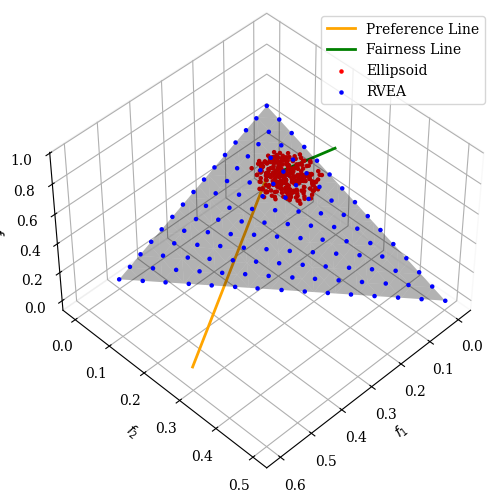

In [5]:
plot = Scatter(legend=True)

fair = 1/ref_dir
fair = fair/np.linalg.norm(fair)

plot.add(problem.pareto_front(ref_dirs), plot_type="surface", color="black", alpha=0.3)

plot.add(np.vstack([np.zeros(3), ref_dir]), plot_type="line", color="orange", linewidth=2, label="Preference Line")
plot.add(np.vstack([np.zeros(3), fair]), plot_type="line", color="green", linewidth=2, label="Fairness Line")

plot.add(res.F, color="red", s=5, label="Ellipsoid")
plot.add(res_r.F, color="blue", s=5, label="RVEA")

plot.show()

In [ ]:
# PF.
pf = problem.pareto_front(ref_dirs)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=pf[:,0], y=pf[:,1], z=pf[:,2],
    mode="markers",
    marker=dict(size=1, color="black"),
    name="Pareto front"
))

# Preference line.
fig.add_trace(go.Scatter3d(
    x=[0, ref_dir[0]], y=[0, ref_dir[1]], z=[0, ref_dir[2]],
    mode="lines", line=dict(color="orange", width=5),
    name="Preference Line"
))

# Fairness line.
fig.add_trace(go.Scatter3d(
    x=[0, fair[0]], y=[0, fair[1]], z=[0, fair[2]],
    mode="lines", line=dict(color="green", width=5),
    name="Fairness Line"
))

# Ellipsoid.
fig.add_trace(go.Scatter3d(
    x=res.F[:,0], y=res.F[:,1], z=res.F[:,2],
    mode="markers", marker=dict(color="red", size=3),
    name="Ellipsoid"
))

# RVEA.
fig.add_trace(go.Scatter3d(
    x=res_r.F[:,0], y=res_r.F[:,1], z=res_r.F[:,2],
    mode="markers", marker=dict(color="blue", size=3),
    name="RVEA"
))

fig.update_layout(scene=dict(
    xaxis_title="f1",
    yaxis_title="f2",
    zaxis_title="f3"
))

fig.show()


### Run the Ellipsoid-based approach with a higher beta value

In [7]:
problem = get_problem("dtlz1", n_obj=3)

algorithm = DQMOO(ref_dir, pop_size=300, beta=5, gamma=0.1, adapt_gamma=True)

res2 = minimize(
    problem,
    algorithm,
    termination=('n_gen', 1000),
    seed=0,
    verbose=True
    )

n_gen  |  n_eval  | n_nds  |      igd      |       gd     
     1 |      300 |    300 |  4.054163E+01 |  3.916855E+02
     2 |      600 |     23 |  4.054163E+01 |  2.260569E+02
     3 |      900 |     13 |  4.054163E+01 |  1.091471E+02
     4 |     1200 |     10 |  4.054163E+01 |  9.536348E+01
     5 |     1500 |     11 |  3.654058E+01 |  9.289469E+01
     6 |     1800 |      8 |  3.654058E+01 |  8.517453E+01
     7 |     2100 |      9 |  3.654058E+01 |  6.172325E+01
     8 |     2400 |     12 |  3.654058E+01 |  6.437396E+01
     9 |     2700 |     15 |  3.654058E+01 |  5.367931E+01
    10 |     3000 |     11 |  1.386491E+01 |  4.589496E+01
    11 |     3300 |      9 |  1.373278E+01 |  3.198976E+01
    12 |     3600 |      9 |  1.373278E+01 |  2.975270E+01
    13 |     3900 |     10 |  7.8841221295 |  3.033260E+01
    14 |     4200 |      7 |  7.8841221295 |  2.557398E+01
    15 |     4500 |      7 |  7.8841221295 |  2.399603E+01
    16 |     4800 |     11 |  7.8841221295 |  1.878075E+

### Plot solutions, ref_dir line, the fair line and PF

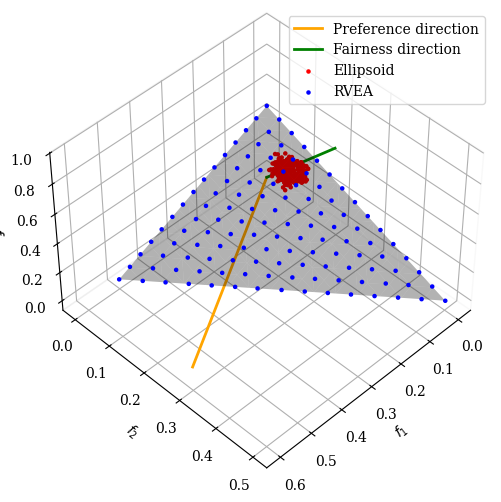

In [8]:
plot = Scatter(legend=True)

fair = 1/ref_dir
fair = fair/np.linalg.norm(fair)

plot.add(problem.pareto_front(ref_dirs), plot_type="surface", color="black", alpha=0.3)

plot.add(np.vstack([np.zeros(3), ref_dir]), plot_type="line", color="orange", linewidth=2, label="Preference direction")
plot.add(np.vstack([np.zeros(3), fair]), plot_type="line", color="green", linewidth=2, label="Fairness direction")

plot.add(res2.F, color="red", s=5, label="Ellipsoid")
plot.add(res_r.F, color="blue", s=5, label="RVEA")

plot.show()

In [ ]:
# PF.
pf = problem.pareto_front(ref_dirs)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=pf[:,0], y=pf[:,1], z=pf[:,2],
    mode="markers",
    marker=dict(size=1, color="black"),
    name="Pareto front"
))

# Preference line.
fig.add_trace(go.Scatter3d(
    x=[0, ref_dir[0]], y=[0, ref_dir[1]], z=[0, ref_dir[2]],
    mode="lines", line=dict(color="orange", width=5),
    name="Preference Line"
))

# Fairness line.
fig.add_trace(go.Scatter3d(
    x=[0, fair[0]], y=[0, fair[1]], z=[0, fair[2]],
    mode="lines", line=dict(color="green", width=5),
    name="Fairness Line"
))

# Ellipsoid.
fig.add_trace(go.Scatter3d(
    x=res2.F[:,0], y=res2.F[:,1], z=res2.F[:,2],
    mode="markers", marker=dict(color="red", size=3),
    name="Ellipsoid"
))

# RVEA.
fig.add_trace(go.Scatter3d(
    x=res_r.F[:,0], y=res_r.F[:,1], z=res_r.F[:,2],
    mode="markers", marker=dict(color="blue", size=3),
    name="RVEA"
))

fig.update_layout(scene=dict(
    xaxis_title="f1",
    yaxis_title="f2",
    zaxis_title="f3"
))

fig.show()


## Performance metrics comparison

### IGD+

In [10]:
pf = problem._calc_pareto_front(ref_dirs)
ind = IGDPlus(pf)

print("IGD+ RVEA: ", ind(res_r.F))
print("IGD+ ELL: ", ind(res2.F))

IGD+ RVEA:  0.0005035423518121037
IGD+ ELL:  0.1449228401709384


### R-metric algorithm application

In [11]:
# Reference point - origin.
# z_r = np.array([0.]*3)

# Reference point.
z_r = np.array(fair / 3)
# Worst point.
z_w = np.array(fair)
# Preference direction (fairness).
w = np.array(fair)
# Hypercube side.
extent = 0.2

# Ellipsoid - higher beta value.
z_p = pivot_point(res2.F, z_r, w)
S_trimmed = trim(res2.F, z_p, extent)
iso_p = iso_ASF_point(z_p, z_r, z_w)
S_transferred = transfer(S_trimmed, z_p, iso_p)

# RVEA.
z_p_r = pivot_point(res_r.F, z_r, w)
S_trimmed_r = trim(res_r.F, z_p_r, extent)
iso_p = iso_ASF_point(z_p_r, z_r, z_w)
S_transferred_r = transfer(S_trimmed_r, z_p_r, iso_p)

### Plot transferred solutions, reference/worst point and pivot points

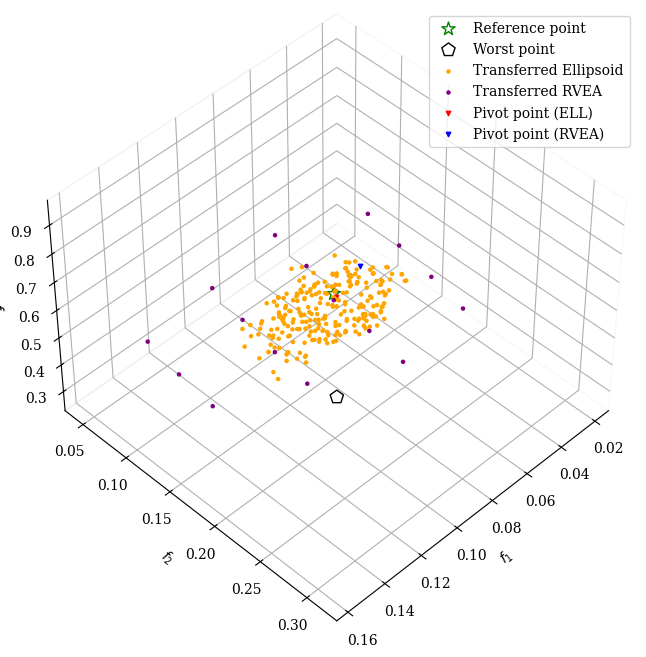

In [12]:
problem = get_problem("dtlz1", n_obj=3)

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=30)

plot = Scatter(legend="True", figsize=(10, 8))

# plot.add(problem.pareto_front(ref_dirs), plot_type="surface", color="black", alpha=0.3)

# plot.add(np.vstack([np.zeros(3), ref_dir]), plot_type="line", color="black", linewidth=2, label="Preference direction")
# plot.add(np.vstack([np.zeros(3), fair]), plot_type="line", color="green", linewidth=2, label="Fairness direction")

# plot.add(res2.F, color="red", s=5, label="Ellipsoid")
# plot.add(res_r.F, color="blue", s=5, label="RVEA")

plot.add(z_r, facecolors="none", edgecolors="green", marker="*", s=100, label="Reference point")
plot.add(z_w, facecolors="none", edgecolors="black", marker="p", s=100, label="Worst point")

plot.add(S_transferred, color="orange", s=5, label="Transferred Ellipsoid")
plot.add(S_transferred_r, color="purple", s=5, label="Transferred RVEA")

plot.add(z_p, color="red", marker="v", s=10, label="Pivot point (ELL)")
plot.add(z_p_r, color="blue", marker="v", s=10, label="Pivot point (RVEA)")

plot.show()

In [ ]:
fig = go.Figure()

# PF.
fig.add_trace(go.Scatter3d(
    x=pf[:,0], y=pf[:,1], z=pf[:,2],
    mode="markers",
    marker=dict(size=1, color="black"),
    name="Pareto front"
))

# Reference point.
fig.add_trace(go.Scatter3d(
    x=[z_r[0]], y=[z_r[1]], z=[z_r[2]],
    mode="markers",
    marker=dict(size=8, color="green", symbol="diamond"),
    name="Reference point"
))

# Worst point.
fig.add_trace(go.Scatter3d(
    x=[z_w[0]], y=[z_w[1]], z=[z_w[2]],
    mode="markers",
    marker=dict(size=8, color="black", symbol="diamond"),
    name="Worst point"
))

# Transferred Ellipsoid.
fig.add_trace(go.Scatter3d(
    x=S_transferred[:,0], y=S_transferred[:,1], z=S_transferred[:,2],
    mode="markers",
    marker=dict(size=4, color="orange"),
    name="Transferred Ellipsoid"
))

# Transferred RVEA.
fig.add_trace(go.Scatter3d(
    x=S_transferred_r[:,0], y=S_transferred_r[:,1], z=S_transferred_r[:,2],
    mode="markers",
    marker=dict(size=4, color="purple"),
    name="Transferred RVEA"
))

# Pivot point (ELL).
fig.add_trace(go.Scatter3d(
    x=[z_p[0]], y=[z_p[1]], z=[z_p[2]],
    mode="markers",
    marker=dict(size=6, color="red", symbol="cross"),
    name="Pivot point (ELL)"
))

# Pivot point (RVEA).
fig.add_trace(go.Scatter3d(
    x=[z_p_r[0]], y=[z_p_r[1]], z=[z_p_r[2]],
    mode="markers",
    marker=dict(size=6, color="blue", symbol="cross"),
    name="Pivot point (RVEA)"
))

fig.update_layout(
    scene=dict(
        xaxis_title="f1",
        yaxis_title="f2",
        zaxis_title="f3"
    ),
    width=800,
    height=600,
    legend=dict(x=0.02, y=0.98)
)

fig.show()

### Compute IGD+ R-metric

In [14]:
# Transfer the PF.
z_p = pivot_point(problem.pareto_front(ref_dirs), z_r, w)
S_trimmed = trim(problem.pareto_front(ref_dirs), z_p, extent)
iso_p = iso_ASF_point(z_p, z_r, z_w)
P_transferred = transfer(S_trimmed, z_p, iso_p)

# Compute IGD+ WRT the transferred PF.
ind = IGDPlus(P_transferred)
print("IGD+ RVEA: ", ind(S_transferred_r))

ind = IGDPlus(P_transferred)
print("IGD+ ELL: ", ind(S_transferred))

IGD+ RVEA:  0.01983924272584563
IGD+ ELL:  0.019278106764904865


# 10-objective problem example

## Experiment runs

### Initialize and run the Ellipsoid-based approach

In [25]:
problem = get_problem("dtlz1", n_var=14, n_obj=10)

ref_dir = np.array([0.05]*10)
ref_dir[0] = 0.3
ref_dir[1] = 0.3


algorithm = DQMOO(ref_dir, pop_size=300, beta=4, gamma=.1, adapt_gamma=True)

res10_ada = minimize(
    problem,
    algorithm,
    termination=('n_gen', 100),
    seed=0,
    verbose=True
    )


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      300 |    300 |             - |             -
     2 |      600 |    139 |  0.0061338559 |         ideal
     3 |      900 |    116 |  0.7960736223 |         nadir
     4 |     1200 |    130 |  2.4268326900 |         nadir
     5 |     1500 |    128 |  0.0263073404 |         ideal
     6 |     1800 |    114 |  1.2925536019 |         nadir
     7 |     2100 |    134 |  0.0039018774 |         ideal
     8 |     2400 |    128 |  0.7182107369 |         nadir
     9 |     2700 |    122 |  2.1315733654 |         nadir
    10 |     3000 |    139 |  0.0080359045 |         ideal
    11 |     3300 |    151 |  0.3966679691 |         nadir
    12 |     3600 |    156 |  0.0078274501 |         ideal
    13 |     3900 |    162 |  0.0098422065 |         ideal
    14 |     4200 |    138 |  1.1427064194 |         nadir
    15 |     4500 |    138 |  0.2738062966 |         nadir
    16 |     4800 |    138 |  0.0074090657 |         ide

### Initialize and run the RVEA baseline

In [26]:
problem = get_problem("dtlz1", n_var=14, n_obj=10)

ref_dirs = get_local_ref_dirs(1 / ref_dir, ndim=10, n_partitions=11, alpha=10)
sub_dirs = np.random.choice(len(ref_dirs), int(len(ref_dirs) / 20), replace=False)

algorithm = RVEA(ref_dirs[sub_dirs], pop_size=300)

res10_rvea = minimize(
    problem,
    algorithm,
    termination=('n_gen', 100),
    seed=0,
    verbose=True
    )

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      300 |    300 |             - |             -
     2 |      600 |     28 |  0.0361058596 |         ideal
     3 |      900 |     67 |  0.0230574688 |         ideal
     4 |     1200 |     96 |  0.0056280191 |         ideal
     5 |     1500 |    125 |  0.7795411887 |         nadir
     6 |     1800 |    156 |  0.0028482580 |         ideal
     7 |     2100 |    198 |  0.0031837480 |         ideal
     8 |     2400 |    231 |  0.0080934535 |         ideal
     9 |     2700 |    271 |  0.0039095034 |         ideal
    10 |     3000 |    303 |  0.5989817532 |         nadir
    11 |     3300 |    282 |  0.0061270215 |         ideal
    12 |     3600 |    330 |  0.3834648496 |         nadir
    13 |     3900 |    369 |  0.0842527737 |         nadir
    14 |     4200 |    409 |  0.1744103731 |         nadir
    15 |     4500 |    450 |  0.0042721280 |         ideal
    16 |     4800 |    471 |  0.2757744324 |         nad

## Performance metrics comparison

### IGD+

In [27]:
pf = problem._calc_pareto_front(ref_dirs)

ind = IGDPlus(pf[np.random.choice(len(pf), 10000, replace=False)])
print("IGD+ RVEA: ", ind(res10_rvea.F))

# ind = IGDPlus(pf)
ind = IGDPlus(pf[np.random.choice(len(pf), 10000, replace=False)])
print("IGD+ ELL: ", ind(res10_ada.F))

IGD+ RVEA:  0.8182367259193838
IGD+ ELL:  0.00878026061217518


### R-metrics

In [28]:
fair = 1/ref_dir
fair = fair/np.linalg.norm(fair)

# Reference point - origin.
# z_r = np.array([0.]*3)

# Reference point.
z_r = np.array(fair / 3)
# Worst point.
z_w = np.array(fair * 3)
# Preference direction (fairness).
w = np.array(fair)
# Hypercube side.
extent = 0.2

# Ellipsoid.
z_p = pivot_point(res10_ada.F, z_r, w)
S_trimmed = trim(res10_ada.F, z_p, extent)
iso_p = iso_ASF_point(z_p, z_r, z_w)
S_transferred = transfer(S_trimmed, z_p, iso_p)

# RVEA.
z_p_r = pivot_point(res10_rvea.F, z_r, w)
S_trimmed_r = trim(res10_rvea.F, z_p_r, extent)
iso_p = iso_ASF_point(z_p_r, z_r, z_w)
S_transferred_r = transfer(S_trimmed_r, z_p_r, iso_p)

In [29]:
# Transfer the PF.
ref_dirs = get_local_ref_dirs(1/ref_dir, ndim = 10, n_partitions = 11, alpha = 10)

z_p = pivot_point(problem.pareto_front(ref_dirs), z_r, w)
S_trimmed = trim(problem.pareto_front(ref_dirs), z_p, extent)
iso_p = iso_ASF_point(z_p, z_r, z_w)
P_transferred = transfer(S_trimmed, z_p, iso_p)

ind = IGDPlus(P_transferred[sub_dirs])
print("IGD+ RVEA: ", ind(S_transferred_r))

ind = IGDPlus(P_transferred[sub_dirs])
print("IGD+ ELL: ", ind(S_transferred))

IGD+ RVEA:  1.3814114962686024
IGD+ ELL:  0.017391521992284206


### MonteCarlo HV

In [30]:
ind = ApproximateMonteCarloHypervolume(ref_point=z_w, n_samples=10**4)
hv_q = ind._calc(z_w,S_transferred_r)[0]
print("HV RVEA:", hv_q)

ind = ApproximateMonteCarloHypervolume(ref_point=z_w, n_samples=10**4)
hv_q = ind._calc(z_w,S_transferred)[0]
print("HV ELL:", hv_q)

HV RVEA: 3.134702186321601e-05
HV ELL: 0.030902689386020817


## Visualization via Radviz maps

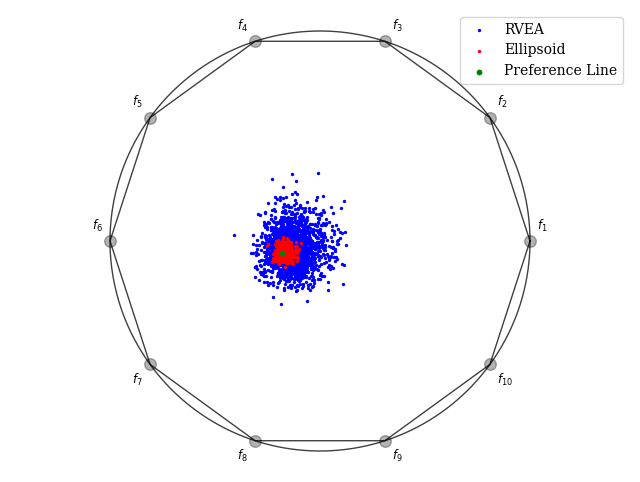

In [34]:

r = Radviz(legend=True)

r.add(res10_rvea.F, color="blue", label="RVEA", s=2)
r.add(res10_ada.F, color="red", label="Ellipsoid", s=2)

r.add(1 / ref_dir, color="green", label="Preference Line", s=10)

r.show()

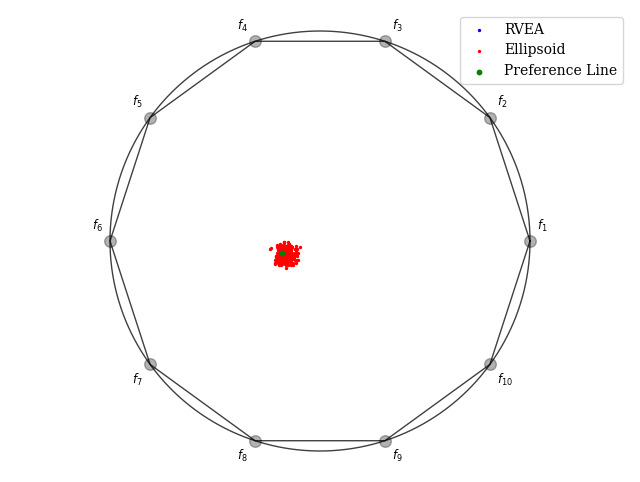

In [42]:
r = Radviz(legend=True)

r.add(S_transferred_r, color="blue", label="RVEA", s=2)
r.add(S_transferred, color="red", label="Ellipsoid", s=2)

r.add(1 / ref_dir, color="green", label="Preference Line", s=10)

r.show()